In [3]:
import os
import glob
import time
import joblib
import anndata
import numpy as np
import pandas as pd
import pynndescent
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'
from ALLCools.plot import *
from ALLCools.integration import confusion_matrix_clustering
from wmb import brain
from sklearn.preprocessing import OneHotEncoder, normalize



In [4]:
group_name = 'HB'


In [5]:
# adata_merge = anndata.read_h5ad('/home/jzhou_salk_edu/sky_workdir/merfish_integration/merfish_integration_rna/L1/All/All_4533606_aibs10xmerfish.h5ad')
adata_merge = anndata.read_h5ad('aibs10xmerfish.h5ad')
adata_merge


AnnData object with n_obs × n_vars = 76111 × 1
    obs: 'count', 'umi_count', 'L1', 'L2', 'L3', 'L1_annot', 'L2_annot', 'DissectionRegion', 'SubRegion', 'MajorRegion', 'Train', 'cocluster', 'Study', 'blank_count', 'n_counts', 'n_genes', 'tsne_0', 'tsne_1'
    obsm: 'X_pca_corrected', 'X_tsne', 'u43seurat_tsne'

In [6]:
ds = min(10000/adata_merge.shape[0], 4)
count = adata_merge.obs['Study'].value_counts()
r = min(5, count['AIBS_10x'] / count['MERFISH'])
coord_base = "tsne"


(-91.8870475831233, 81.00462521782573)

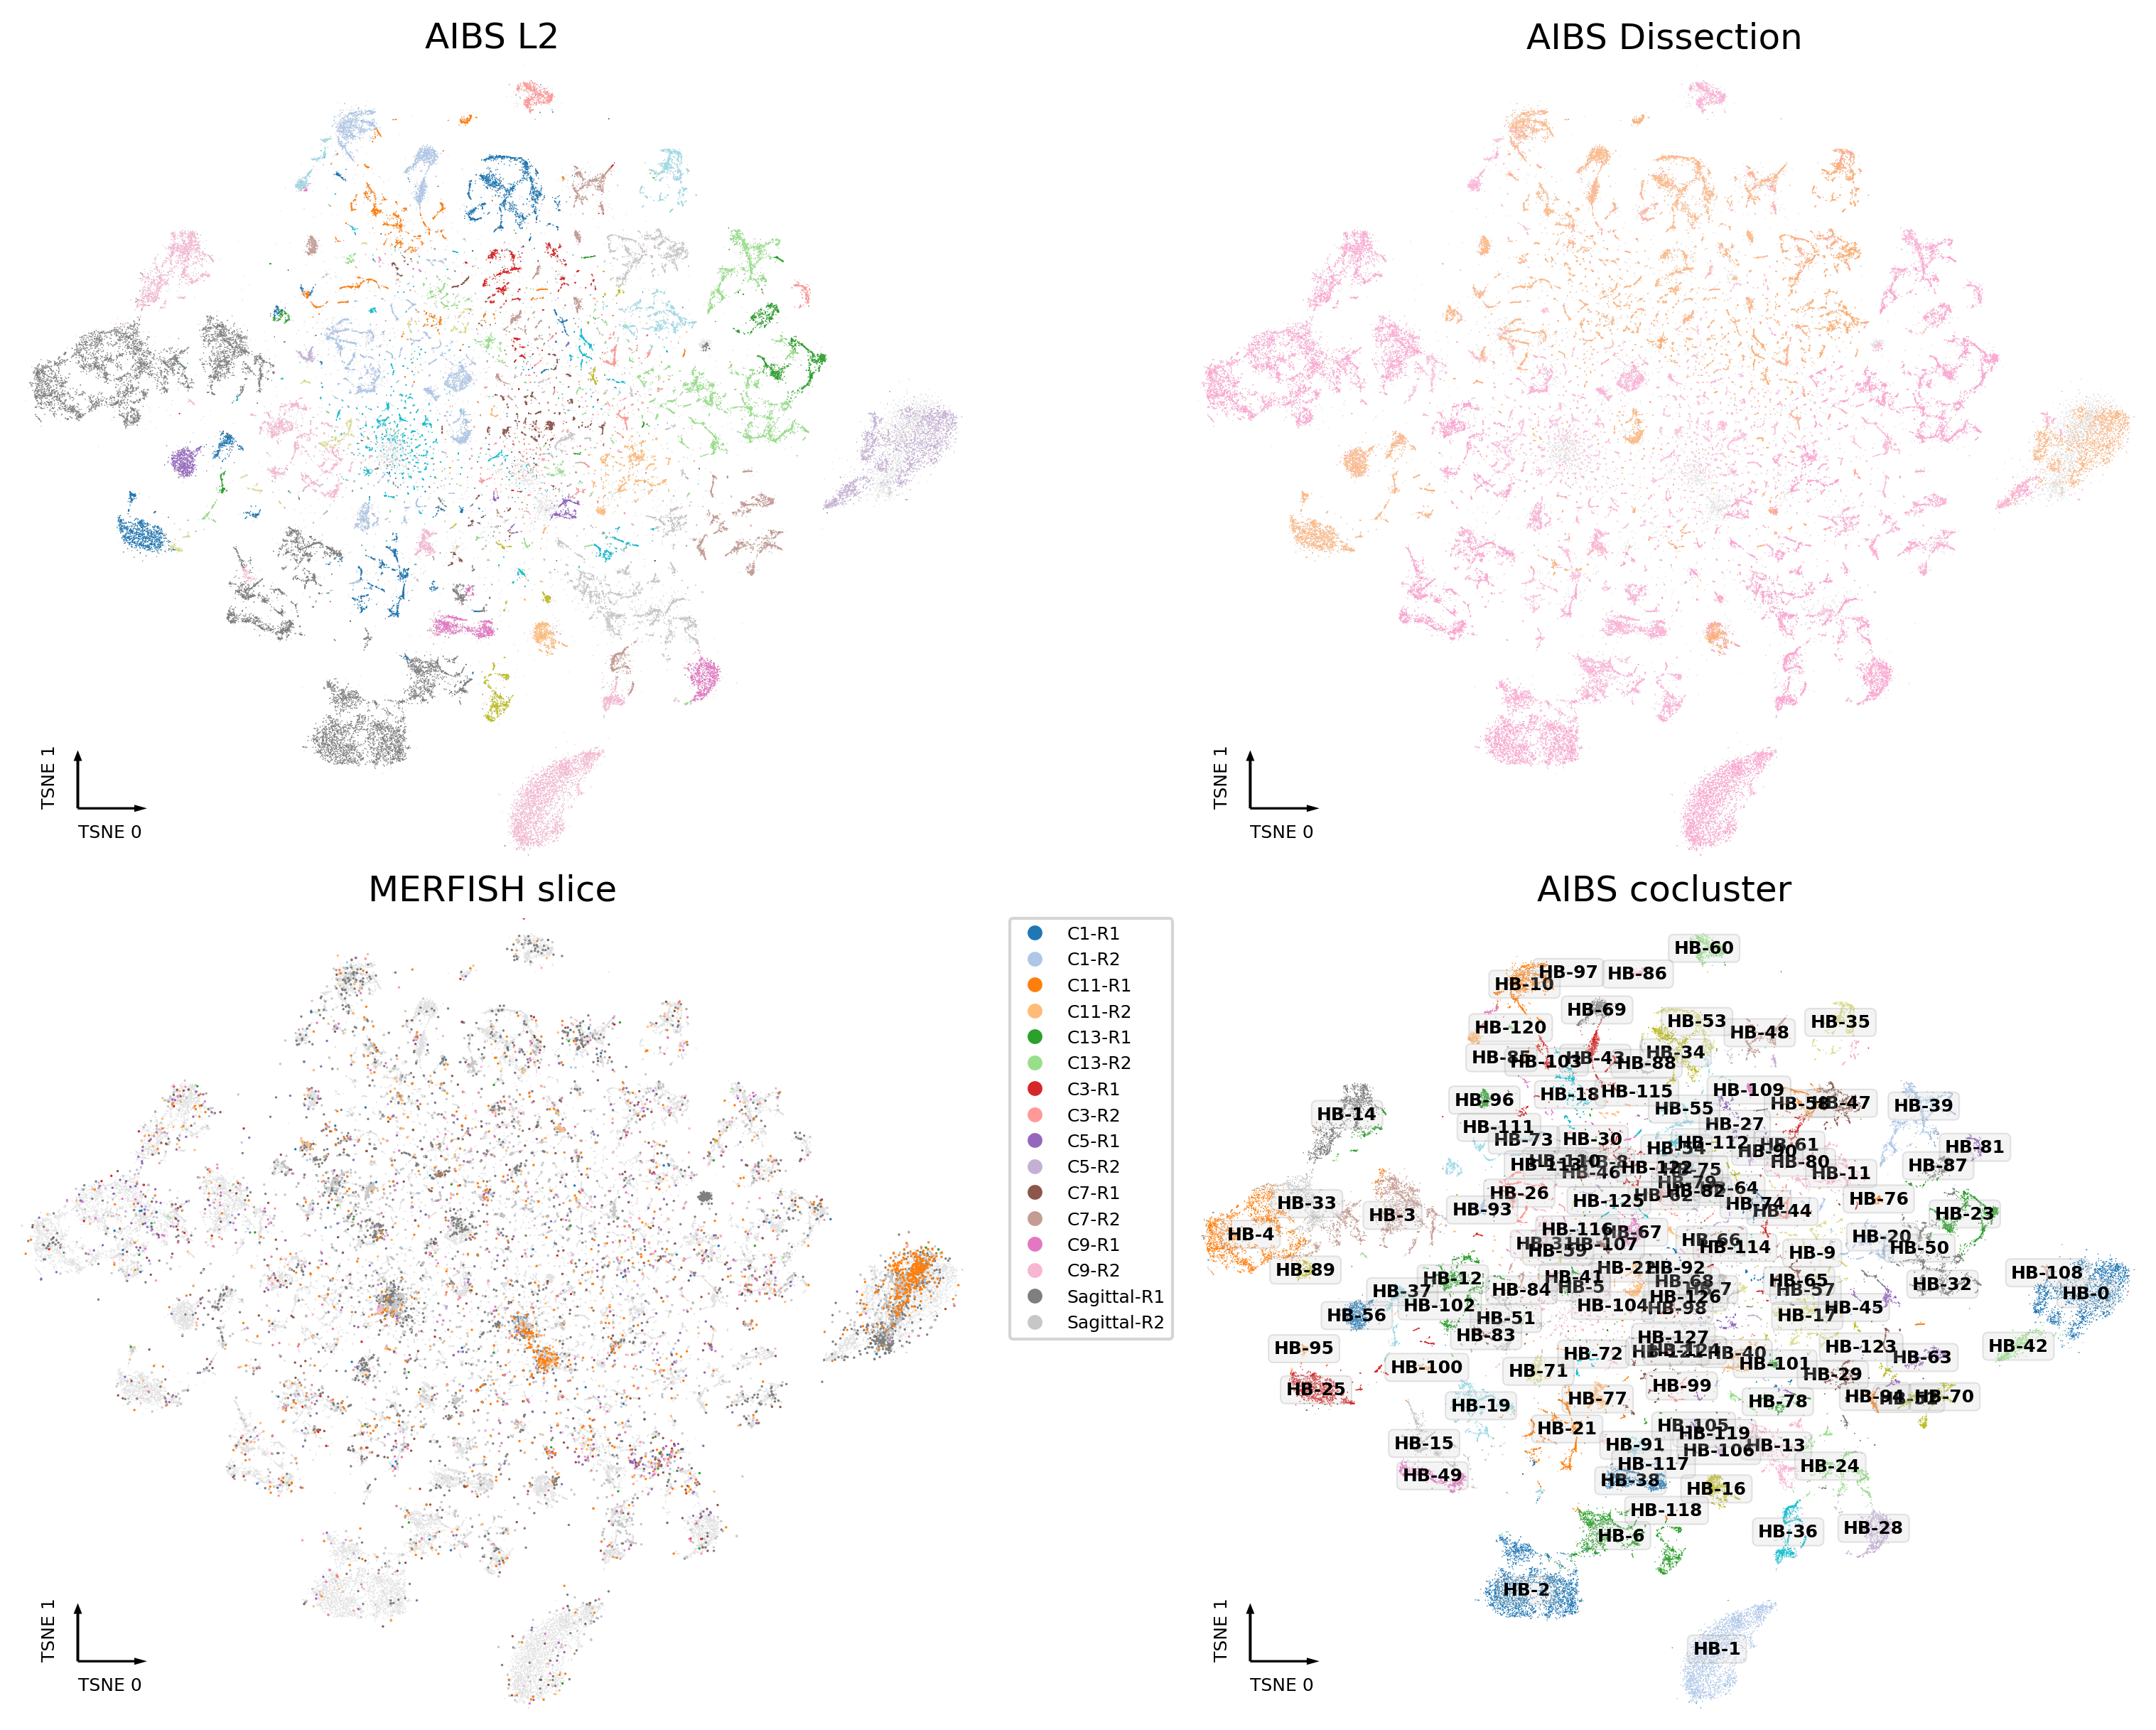

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=300, constrained_layout=True, sharex='all', sharey='all')

tmp = adata_merge.obs.loc[adata_merge.obs['Study']=='AIBS_10x']
# count = tmp['L1_annot_AIBS'].value_counts()
# tmp = tmp[tmp['L1_annot_AIBS'].isin(count.index[count>20])]
ax = axes[0,0]
ax.scatter(adata_merge.obs[f'{coord_base}_0'], adata_merge.obs[f'{coord_base}_1'], c='#e0e0e0', edgecolors='none', s=ds, rasterized=True)
_ = categorical_scatter(data=tmp,
                        ax=ax,
                        coord_base=coord_base,
                        s=ds,
                        hue='L2',
                        # text_anno='L3',
                        palette='tab20',
                        labelsize=6,
                        max_points=None,
                        scatter_kws={'rasterized':True},
                        #show_legend=True,
                        #legend_kws={'ncol':1},
                       )

ax = axes[0,1]
ax.scatter(adata_merge.obs[f'{coord_base}_0'], adata_merge.obs[f'{coord_base}_1'], c='#e0e0e0', edgecolors='none', s=ds, rasterized=True)
_ = categorical_scatter(data=tmp,
                        ax=ax,
                        coord_base=coord_base,
                        s=ds,
                        hue='DissectionRegion',
                        # text_anno='L1_annot',
                        palette=brain.get_dissection_region_palette(),
                        labelsize=6,
                        max_points=None,
                        scatter_kws={'rasterized':True},
                        #show_legend=True,
                        #legend_kws={'ncol':1},
                       )

ax = axes[1,1]
_ = categorical_scatter(data=tmp,
                        ax=ax,
                        coord_base=coord_base,
                        s=ds,
                        hue='cocluster',
                        text_anno='cocluster',
                        palette='tab20',
                        labelsize=6,
                        max_points=None,
                        scatter_kws={'rasterized':True},
                        # show_legend=True,
                        # legend_kws={'ncol':1},
                       )

tmp = adata_merge.obs.loc[adata_merge.obs['Study']=='MERFISH']
tmp['batch'] = [f'{"-".join(xx.split("-")[:2])}' for xx in tmp.index]
ax = axes[1,0]
ax.scatter(adata_merge.obs[f'{coord_base}_0'], adata_merge.obs[f'{coord_base}_1'], c='#e0e0e0', edgecolors='none', s=ds, rasterized=True)
_ = categorical_scatter(data=tmp,
                        ax=ax,
                        coord_base=coord_base,
                        s=ds*r,
                        hue='batch',
                        # text_anno='batch',
                        palette='tab20',
                        labelsize=6,
                        max_points=None,
                        scatter_kws={'rasterized':True},
                        show_legend=True,
                        legend_kws={'ncol':1},
                       )

for i,xx in enumerate(['AIBS L2', 'AIBS Dissection', 'MERFISH slice', 'AIBS cocluster']):
    axes.flatten()[i].set_title(xx, fontsize=12)

ax.set_xlim(adata_merge.obs[f'{coord_base}_0'].min(), adata_merge.obs[f'{coord_base}_0'].max())
ax.set_ylim(adata_merge.obs[f'{coord_base}_1'].min(), adata_merge.obs[f'{coord_base}_1'].max())


# plt.savefig(f'/gale/netapp/entex/CEMBA_RS2/RS1/plot/cell_{adata_merge.shape[0]}_Neu_10xAIBS2geneCH.pdf', transparent=True)




In [9]:
tmp = adata_merge.obs.loc[adata_merge.obs['Study']=='AIBS_10x']
count = tmp["L2_annot"].value_counts()
leg = np.sort(count.index)


(-91.8870475831233, 81.00462521782573)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


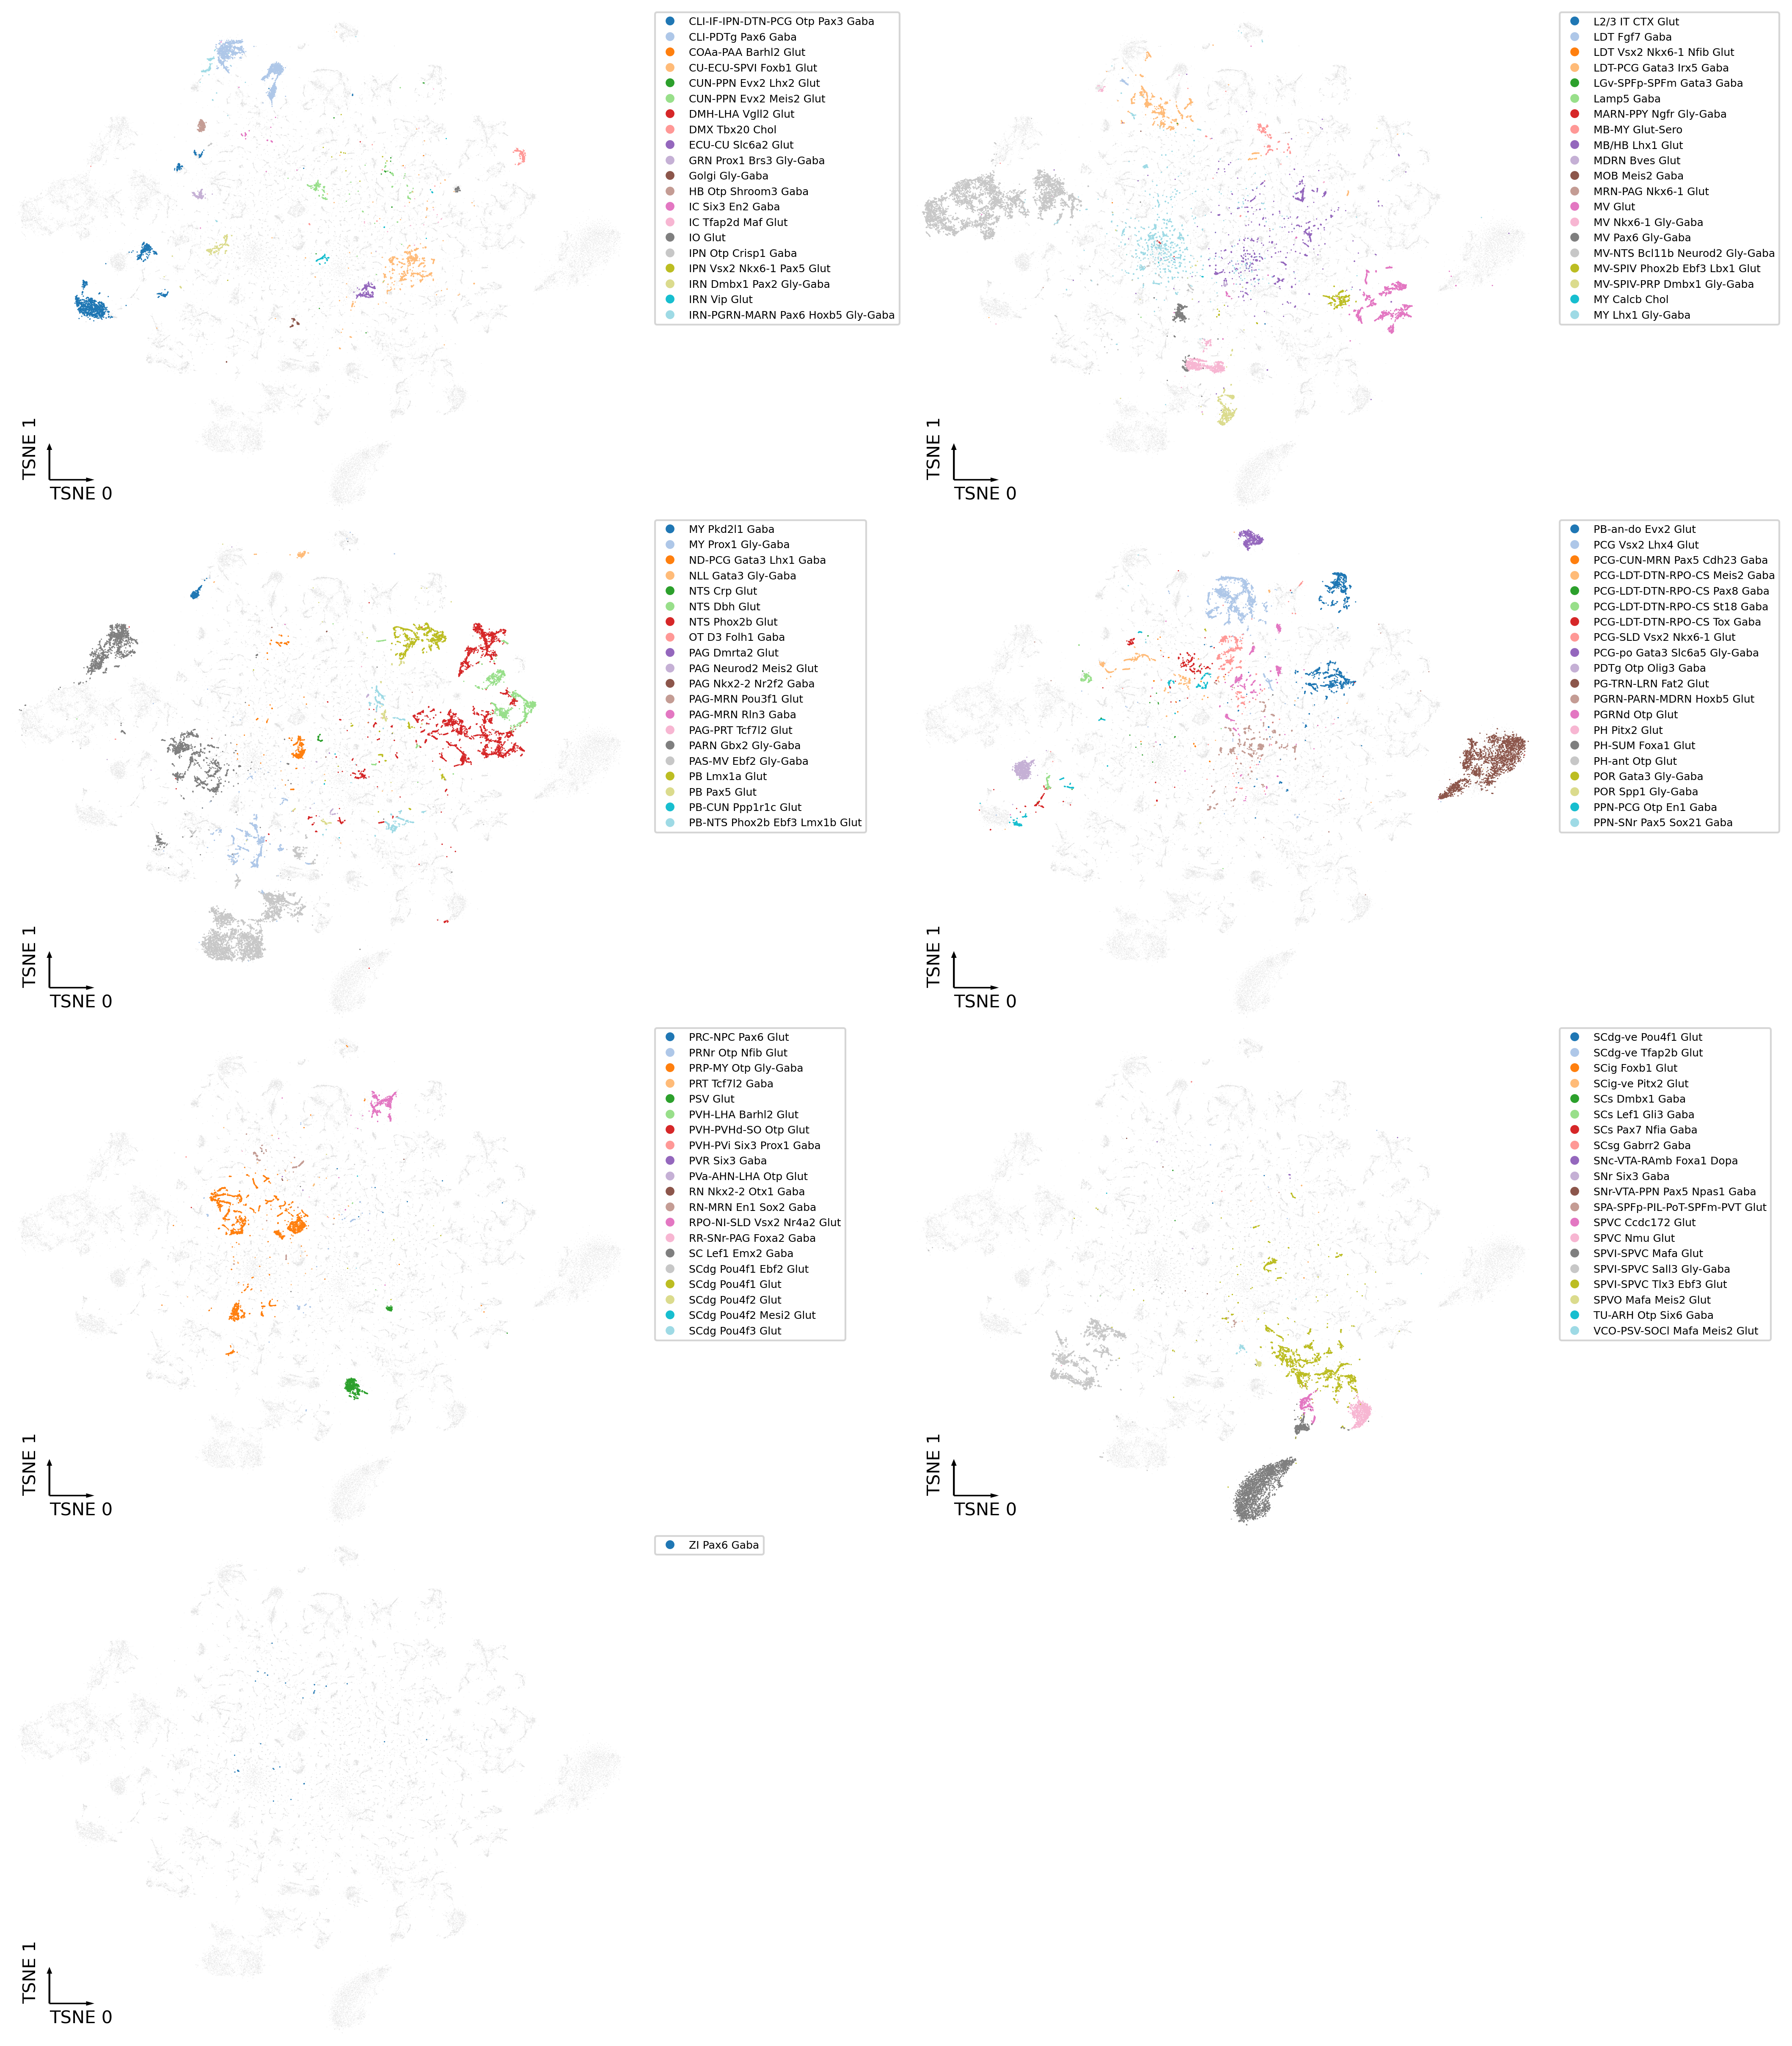

In [10]:
nplot = (count.shape[0] - 1) // 20 + 1
nrow = (nplot - 1) // 2 + 1
ncol = 2
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * 7, nrow * 4), dpi=300, constrained_layout=True, sharex='all', sharey='all')
for i in range(nplot):
    legtmp = leg[(i * 20) : ((i + 1) * 20)]
    tmp0 = tmp.loc[tmp["L2_annot"].isin(legtmp)]
    ax = axes.flatten()[i]
    ax.scatter(
        adata_merge.obs[f"{coord_base}_0"],
        adata_merge.obs[f"{coord_base}_1"],
        c="#e0e0e0",
        edgecolors="none",
        s=ds,
        alpha=0.5,
        rasterized=True,
    )
    _ = categorical_scatter(
        data=tmp0,
        ax=ax,
        coord_base=coord_base,
        s=ds*4,
        hue="L2_annot",
        # text_anno='L2_annot',
        palette="tab20",
        labelsize=10,
        max_points=None,
        scatter_kws={"rasterized": True},
        show_legend=True,
        legend_kws={"ncol": 1, "fontsize": 6},
    )
if nrow * ncol > nplot:
    for i in range(nplot, nrow * ncol):
        axes.flatten()[i].axis("off")

ax.set_xlim(adata_merge.obs[f'{coord_base}_0'].min(), adata_merge.obs[f'{coord_base}_0'].max())
ax.set_ylim(adata_merge.obs[f'{coord_base}_1'].min(), adata_merge.obs[f'{coord_base}_1'].max())

# plt.savefig(f'cell_{adata_merge.shape[0]}_{t}_AIBS10x_CEMBAsnmC_CEMBAEpiRetro.AIBSL2.pdf', transparent=True)


In [11]:
aibs_cell = (adata_merge.obs['Study']=='AIBS_10x')
merfish_cell = (adata_merge.obs['Study']=='MERFISH')
print(aibs_cell.sum(), merfish_cell.sum())


67701 8410


In [12]:
sd = 1
start_time = time.time()
index = pynndescent.NNDescent(adata_merge.obsm['X_pca_corrected'][aibs_cell], metric='euclidean', n_neighbors=min(50, aibs_cell.sum()), random_state=0, n_jobs=-1)
print(time.time() - start_time)
G, D = index.query(adata_merge.obsm['X_pca_corrected'][merfish_cell], k=min(25, aibs_cell.sum()))
print(time.time() - start_time)
np.savez('MERFISH_AIBS10xNN.npz', G=G, D=D, aibs_cell=adata_merge.obs.index[aibs_cell], merfish_cell=adata_merge.obs.index[merfish_cell])


111.68570256233215
122.7520546913147


In [13]:
chunk_size = 50000
sd = 1
start_time = time.time()
cellfilter = D[:, -1] == 0
D = 1 - D / D[:, -1][:, None]
D[cellfilter] = 1
D = 1 - np.exp(-D * (sd**2) / 4)
D = D / (np.sum(D, axis=1) + 1e-6)[:, None]
print(time.time() - start_time)


0.002792835235595703


In [14]:
aibs_cell = aibs_cell.index[aibs_cell]
merfish_cell = merfish_cell.index[merfish_cell]

In [15]:
enc = OneHotEncoder()
# enc.fit(adata_merge.obs.loc[aibs_cell, ['L3']].values.astype(str))
labelref = enc.fit_transform(adata_merge.obs.loc[aibs_cell, 'cocluster'].astype(str)[:, None])
cluster = pd.DataFrame(index=merfish_cell, columns=["cocluster", "score"], dtype=str)
for chunk_start in range(0, len(merfish_cell), chunk_size):
    result = (
        D[chunk_start : (chunk_start + chunk_size), :, None]
        * labelref[G[chunk_start : (chunk_start + chunk_size)].flatten()]
        .toarray()
        .reshape((-1, min(25, len(aibs_cell)), enc.categories_[0].shape[0]))
    ).sum(axis=1)
    result = pd.DataFrame(
        result,
        columns=enc.categories_[0],
        index=merfish_cell[chunk_start : (chunk_start + chunk_size)],
    )
    result = result.loc[:, result.columns != "nan"]
    cluster.loc[result.index, "cocluster"] = result.idxmax(axis=1).values
    cluster.loc[result.index, "score"] = result.max(axis=1).values
    print(chunk_start)

print(time.time() - start_time)
cluster.to_hdf("MERFISH_cocluster.hdf", key="data")


0
0.13845515251159668
